# Gendered perspectives on character.


In [38]:
import csv, math
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from adjustText import adjust_text
%matplotlib inline

In [6]:
data = pd.read_csv('chartable.tsv', sep = '\t')

In [61]:
lexicon = pd.read_csv('lexicon.tsv', sep = '\t')
vocab = set(lexicon.word[0:1800])

In [32]:
def dunnings(vectora, vectorb):
    ''' Calculates Dunning's log-likelihood (a signed version)
    '''
    assert len(vectora) == len(vectorb)
    veclen = len(vectora)
    totala = np.sum(vectora)
    totalb = np.sum(vectorb)
    totalboth = totala + totalb

    dunningvector = np.zeros(veclen)

    for i in range(veclen):
        if vectora[i] == 0 or vectorb[i] == 0:
            continue
            # Cause you know you're going to get div0 errors.

        try:
            probI = (vectora[i] + vectorb[i]) / totalboth
            probnotI = 1 - probI
            expectedIA = totala * probI
            expectedIB = totalb * probI
            expectedNotIA = totala * probnotI
            expectedNotIB = totalb * probnotI
            expected_table = np.array([[expectedIA, expectedNotIA],
                [expectedIB, expectedNotIB]])
            actual_table = np.array([[vectora[i], (totala - vectora[i])],
                [vectorb[i], (totalb - vectorb[i])]])
            G = np.sum(actual_table * np.log(actual_table / expected_table))

            # take an additional log to make it visualizable
            G = math.log(G)
            # We're going to use a signed version of Dunnings, so features where
            # B is higher than expected will be negative.

            if expectedIB > vectorb[i]:
                G = -G

            dunningvector[i] = G

        except:
            pass
            # There are a million ways to get a div-by-zero or log-zero error
            # in that calculation. I could check them all, or just do this.
            # The vector was initialized with zeroes, which are the default
            # value I want for failed calculations anyhow.

    return dunningvector

In [55]:
data.head()

,year,authgender,chargender,word,wordct,charct
0,1780,m,f,said-cast,1,1
1,1780,m,f,said-half,1,1
2,1780,m,f,begged,1,1
3,1780,m,f,said-rose,1,1
4,1780,m,f,said-account,1,1


In [76]:
# I'm simply going to fix some grammatical issues, for cosmetic reasons
# If you prefer not to, you can delete this. It makes little substantive
# difference.

themap = {'was-seeing': 'was-seen', 'was-saw': 'was-seen', 'was-see': 'was-seen',
          'was-tell': 'was-told', 'was-marry': 'was-married', 'was-love': 'was-loved',
         'was-ask': 'was-asked'}

def fixgrammar(aword):
    if aword in themap:
        return themap[aword]
    else:
        return aword

data['word'] = data['word'].apply(fixgrammar)
vocab = vocab.intersection(set(data.word))

In [77]:
def sumwords(df):
    grouped = df.groupby('word')
    wordsums = grouped.aggregate(np.sum)
    return wordsums.wordct

def sumchars(df):
    grouped = df.groupby('word')
    wordsums = grouped.aggregate(np.sum)
    return wordsums.charct

def dunningsforauthgender(data, authgender):
    perspectiveonmen = data[(data.authgender == authgender) & (data.chargender == 'm')]
    perspectiveonwomen = data[(data.authgender == authgender) & (data.chargender == 'f')]
    mascwords = sumwords(perspectiveonmen).rename('m')
    femwords = sumwords(perspectiveonwomen).rename('f')
    comparison = pd.concat([femwords, mascwords], axis = 1)
    comparison.fillna(0, inplace = True)
    gvals = dunnings(comparison.m, comparison.f)
    comparison = comparison.assign(g = gvals)
    comparison.sort_values(by = 'g', inplace = True)
    
    return comparison

def duncharsforauthgender(data, authgender):
    perspectiveonmen = data[(data.authgender == authgender) & (data.chargender == 'm')]
    perspectiveonwomen = data[(data.authgender == authgender) & (data.chargender == 'f')]
    mascwords = sumchars(perspectiveonmen).rename('m')
    femwords = sumchars(perspectiveonwomen).rename('f')
    comparison = pd.concat([femwords, mascwords], axis = 1)
    comparison.fillna(0, inplace = True)
    gvals = dunnings(comparison.m, comparison.f)
    comparison = comparison.assign(g = gvals)
    comparison.sort_values(by = 'g', inplace = True)
    
    return comparison

f_perspective = dunningsforauthgender(data, 'f')
m_perspective = dunningsforauthgender(data, 'm')

gforf = f_perspective.g.rename('f')
gform = m_perspective.g.rename('m')
twoperspectives = pd.concat([gforf, gform], axis = 1)
twoperspectives.fillna(0, inplace = True)
twoperspectives['word'] = twoperspectives.index
twoperspectives.head()

,f,m,word
'd,5.192914,5.713372,'d
'll,-2.217192,-2.952117,'ll
'm,-1.487285,-1.569018,'m
're,-0.111303,-2.603079,'re
's,-6.029262,2.402428,'s


In [92]:
def plot_gender_means(words, frametoplot, adjust=True, title=False, label_outliers=True, normalize_axes=False, save=False):
    df = frametoplot.loc[(frametoplot.word.isin(words)),:]
    ax0 = df.plot('m', 'f', kind='scatter', s=50, figsize=(15,15))
    ax0.plot(0, 0, 'r+', ms=15, mew=2, label='(0,0) Gender Neutral')
    
    texts = []
    for x, y, s in zip(df['m'], df['f'], df['word']):
        if label_outliers:
            if (((x < - 4.3) & (y > 4.3)) |((x > 4.3) & (y < -4.3))):
                texts.append(plt.text(x, y, s, size = 11))
            if (((x < -8) & (y < -8)) |((x > 8.5) & (y  > 8.5))):
                texts.append(plt.text(x, y, s, size=11))

    if adjust:
        adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
        
    plt.legend(loc='best')
    plt.ylabel('m     <--     Diff for women writers 1800-2000    -->     f', fontsize=16, )
    plt.xlabel('m     <--     Diff for male writers 1800-2000     -->     f', fontsize=16)
    if title:
        plt.title(title)
    if normalize_axes:
        ylim = ax0.get_ylim()
        xlim = ax0.get_xlim()
        new_low = min(xlim[0], ylim[0])
        new_hi = max(xlim[1], ylim[1])
        plt.ylim(new_low, new_hi)
        plt.xlim(new_low, new_hi)

    if save:
        if title:
            plt.savefig('./{}.png'.format(title))
        else:
            plt.savefig('./genderDiffMeans.png')
    plt.show()

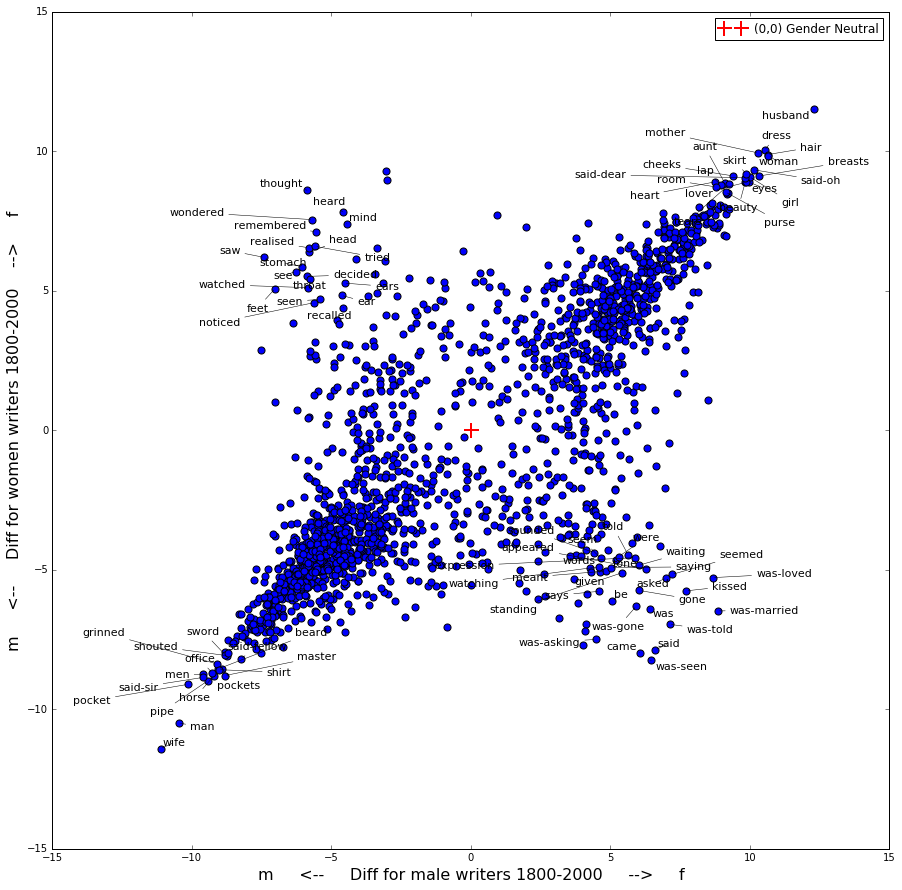

In [93]:
plot_gender_means(vocab, twoperspectives)

In [95]:
# Let's write that to disk for R visualization

outframe = twoperspectives.loc[(twoperspectives.word.isin(vocab)), : ]
things2plot = {'appeared', 'came', 'said', 'was-married', 'was-told', 'was-told', 'asked', 'seemed', 
               'appeared', 'tone', 'expression', 'said-poetry', 'kisses', 'kissed',
               'was-seen', 'words', 'meant', 'wife', 'man', 'sword', 'grinned',
              'man', 'pipe', 'pocket', 'said-sir', 'beard', 'pipe', 'horse', 'shirt',
              'girl', 'purse', 'cheeks', 'said-oh', 'hair', 'breasts', 'aunt',
              'husband', 'dress', 'mother', 'eyes', 'decided', 'ear', 'feet', 'head', 'mind',
              'heard', 'hungry', 'mind', 'noticed', 'realised', 'remembered', 
              'saw', 'see', 'stomach', 'thought', 'throat', 'tried', 'wondered',
              'learned', 'hungry'}

def map2label(word):
    global things2plot
    if word in things2plot:
        return word
    else:
        return ''

outframe = outframe.assign(label = outframe.word.apply(map2label))
outframe.to_csv('data4r.csv', index = False)

In [87]:
obj = twoperspectives[(twoperspectives.m < -3) & (twoperspectives.f > 3)]
obj

,f,m,word
able,3.946090,-4.803446,able
adjusted,3.200341,-3.364185,adjusted
apt,3.053338,-3.798242,apt
awoke,4.916643,-3.376953,awoke
clicked,3.088881,-3.533794,clicked
collected,3.677536,-3.013267,collected
concentrated,3.337734,-3.918539,concentrated
contemporaries,3.420314,-4.067333,contemporaries
decided,5.517144,-5.857164,decided
dialled,4.269939,-3.753164,dialled


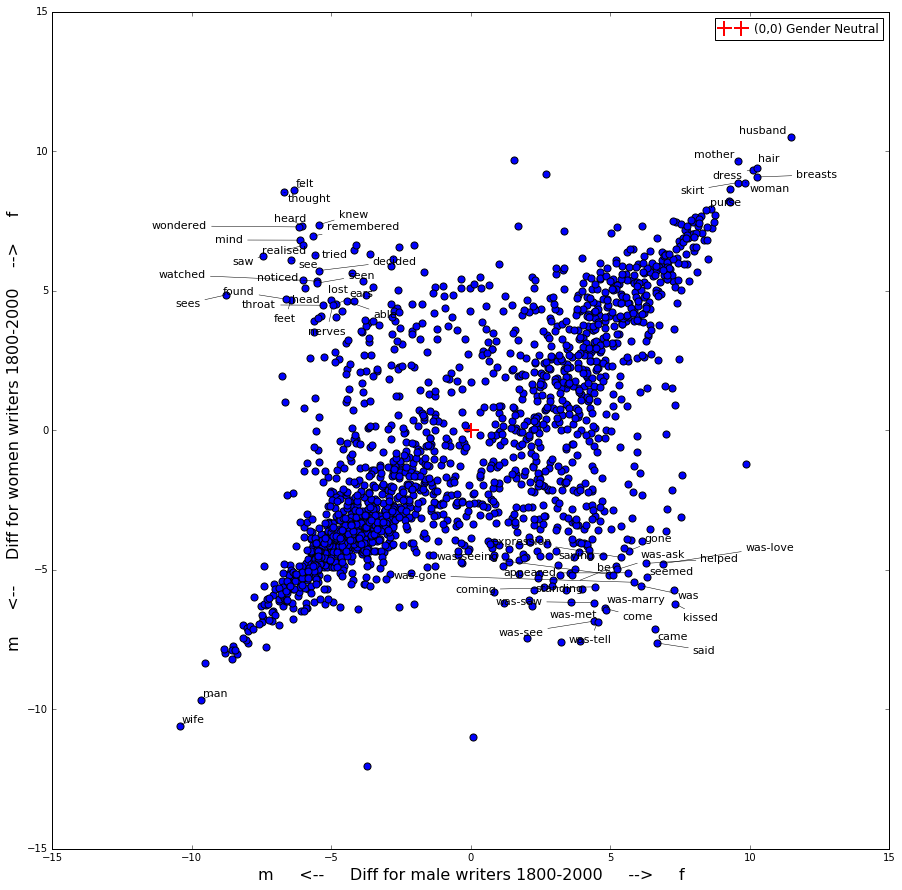

In [71]:
twentieth = data[data.year > 1950]
f_perspective = dunningsforauthgender(twentieth, 'f')
m_perspective = dunningsforauthgender(twentieth, 'm')

gforf = f_perspective.g.rename('f')
gform = m_perspective.g.rename('m')
perspective20 = pd.concat([gforf, gform], axis = 1)
perspective20.fillna(0, inplace = True)
perspective20['word'] = perspective20.index
plot_gender_means(vocab, perspective20)

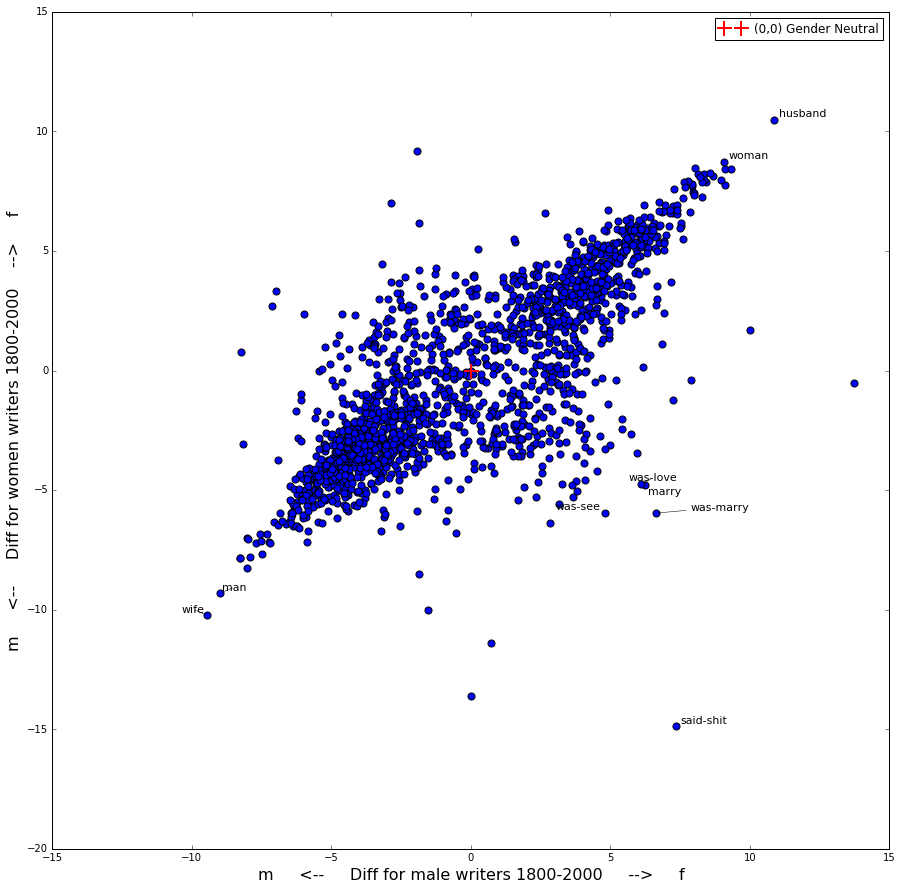

In [70]:
nineteenth = data[data.year < 1900]
f_perspective = dunningsforauthgender(nineteenth, 'f')
m_perspective = dunningsforauthgender(nineteenth, 'm')

gforf = f_perspective.g.rename('f')
gform = m_perspective.g.rename('m')
perspective19 = pd.concat([gforf, gform], axis = 1)
perspective19.fillna(0, inplace = True)
perspective19['word'] = perspective19.index
plot_gender_means(vocab, perspective19)